In [8]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
np.random.seed(2806) # for reproducibility

from keras.datasets import mnist
from keras.models import Sequential
#from keras.layers import containers
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.utils import np_utils

from keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D
from keras.models import Model

%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing

batch_size = 64
nb_classes = 10
nb_epoch = 1

# the data, shuffled and split between train and test sets
(X_train, _), (X_test, _) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [9]:
noise_factor = 0.5
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape) 
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

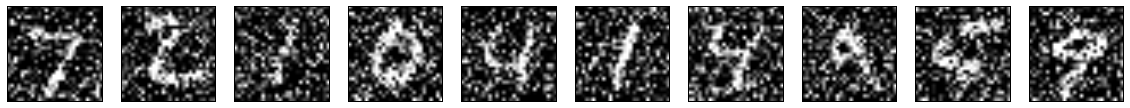

In [10]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### AE without regularizers

In [11]:
input_img = Input(shape=(784,))

nr_encoded = Dense(128, activation='relu')(input_img)
nr_encoded = Dense(64, activation='relu')(nr_encoded)
#nr_encoded = Dense(32, activation='relu')(nr_encoded)

#nr_decoded = Dense(64, activation='relu')(nr_encoded)
nr_decoded = Dense(128, activation='relu')(nr_encoded)
nr_decoded = Dense(784, activation='sigmoid')(nr_decoded)

ae_no_reg = Model(input_img, nr_decoded)
ae_no_reg.compile(optimizer='adadelta', loss='binary_crossentropy')

In [12]:
no_reg_train = ae_no_reg.fit(X_train_noisy, X_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 0s - loss: 0.3206 - val_loss: 0.2649
Epoch 2/50
60000/60000 [==============================] - 0s - loss: 0.2624 - val_loss: 0.2589
Epoch 3/50
60000/60000 [==============================] - 0s - loss: 0.2533 - val_loss: 0.2441
Epoch 4/50
60000/60000 [==============================] - 0s - loss: 0.2337 - val_loss: 0.2227
Epoch 5/50
60000/60000 [==============================] - 0s - loss: 0.2173 - val_loss: 0.2105
Epoch 6/50
60000/60000 [==============================] - 0s - loss: 0.2056 - val_loss: 0.1995
Epoch 7/50
60000/60000 [==============================] - 0s - loss: 0.1954 - val_loss: 0.1898
Epoch 8/50
60000/60000 [==============================] - 0s - loss: 0.1867 - val_loss: 0.1819
Epoch 9/50
60000/60000 [==============================] - 0s - loss: 0.1796 - val_loss: 0.1755
Epoch 10/50
60000/60000 [==============================] - 0s - loss: 0.1742 - val_loss: 0.1712

In [13]:
nr_encoder = Model(input_img, nr_encoded)
# create a placeholder for an encoded (32-dimensional) input
nr_encoded_input = Input(shape=(64,))
# retrieve the last layer of the autoencoder model
nr_decoder_layer = ae_no_reg.layers[-2:]
# create the decoder model
#nr_decoder = Model(nr_encoded_input, nr_decoder_layer[2](nr_decoder_layer[1](nr_decoder_layer[0](nr_encoded_input))))
nr_decoder = Model(nr_encoded_input, nr_decoder_layer[1](nr_decoder_layer[0](nr_encoded_input)))

nr_encoded_imgs = nr_encoder.predict(X_test)
nr_decoded_imgs = nr_decoder.predict(nr_encoded_imgs)

### AE with regularizers

In [27]:
from keras import regularizers

input_img = Input(shape=(784,))

r_encoded = Dense(128, activation='relu')(input_img)
r_encoded = Dense(64, activation='relu', kernel_regularizer=regularizers.l1(10e-5))(r_encoded)
#r_encoded = Dense(64, activation='relu', activity_regularizer=regularizers.l1(5e-7))(r_encoded)
#r_encoded = Dense(32, activation='relu')(r_encoded)

#r_decoded = Dense(64, activation='relu')(r_encoded)
r_decoded = Dense(128, activation='relu')(r_encoded)
r_decoded = Dense(784, activation='sigmoid')(r_decoded)

ae_reg = Model(input_img, r_decoded)
ae_reg.compile(optimizer='adadelta', loss='binary_crossentropy')

In [28]:
reg_train = ae_reg.fit(X_train_noisy, X_train,
                epochs=300,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/300
60000/60000 [==============================] - 0s - loss: 0.3767 - val_loss: 0.3203
Epoch 2/300
60000/60000 [==============================] - 0s - loss: 0.3103 - val_loss: 0.3005
Epoch 3/300
60000/60000 [==============================] - 0s - loss: 0.2911 - val_loss: 0.2808
Epoch 4/300
60000/60000 [==============================] - 0s - loss: 0.2712 - val_loss: 0.2614
Epoch 5/300
60000/60000 [==============================] - 0s - loss: 0.2531 - val_loss: 0.2441
Epoch 6/300
60000/60000 [==============================] - 0s - loss: 0.2392 - val_loss: 0.2316
Epoch 7/300
60000/60000 [==============================] - 0s - loss: 0.2263 - val_loss: 0.2191
Epoch 8/300
60000/60000 [==============================] - 0s - loss: 0.2168 - val_loss: 0.2130
Epoch 9/300
60000/60000 [==============================] - 0s - loss: 0.2116 - val_loss: 0.2079
Epoch 10/300
60000/60000 [==============================] - 0s - loss: 0.2065 - val_lo

In [18]:
r_encoder = Model(input_img, r_encoded)
# create a placeholder for an encoded (32-dimensional) input
r_encoded_input = Input(shape=(64,))
# retrieve the last layer of the autoencoder model
r_decoder_layer = ae_reg.layers[-2:]
# create the decoder model
#r_decoder = Model(r_encoded_input, r_decoder_layer[2](r_decoder_layer[1](r_decoder_layer[0](r_encoded_input))))
r_decoder = Model(r_encoded_input, r_decoder_layer[1](r_decoder_layer[0](r_encoded_input)))

r_encoded_imgs = r_encoder.predict(X_test)
r_decoded_imgs = r_decoder.predict(r_encoded_imgs)

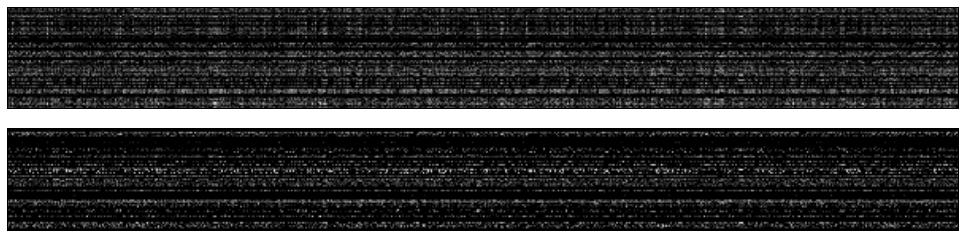

In [19]:
# imgscaler = preprocessing.MinMaxScaler()
# i2 = imgscaler.fit_transform(nr_encoded_imgs)
# i1 = imgscaler.transform(r_encoded_imgs)
thresh = np.mean(r_encoded_imgs)
i1 = nr_encoded_imgs
i2 = r_encoded_imgs
i1[nr_encoded_imgs < thresh] = 0
i2[r_encoded_imgs < thresh] = 0


plt.figure(figsize=(20,4))
plt.subplot(2,1,1)
plt.gray()
plt.imshow(np.abs(np.transpose(i1[0:600,:])))
plt.tick_params(
    axis='both',    # changes apply to both axes
    which='both',   # both major and minor ticks are affected
    bottom='off',   # ticks along the bottom edge are off
    top='off',      # ticks along the top edge are off
    labelbottom='off',
    right='off',
    left='off',
    labelleft='off') # labels along the bottom edge are off
plt.subplot(2,1,2)
plt.imshow(np.abs(np.transpose(i2[0:600,:])))
plt.tick_params(
    axis='both',    # changes apply to both axes
    which='both',   # both major and minor ticks are affected
    bottom='off',   # ticks along the bottom edge are off
    top='off',      # ticks along the top edge are off
    labelbottom='off',
    right='off',
    left='off',
    labelleft='off') # labels along the bottom edge are off

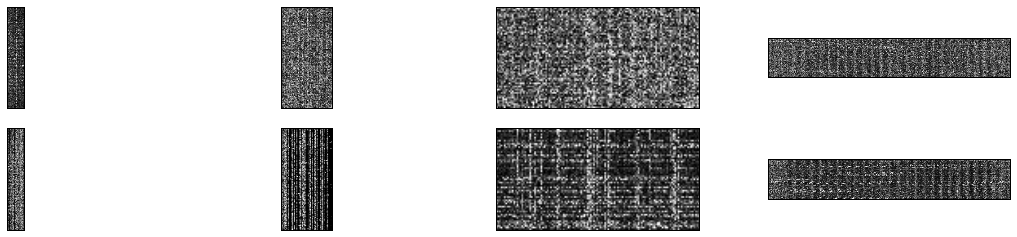

In [29]:
plt.figure(figsize=(20, 4))
plt.gray()
#w1 = np.zeros((1,1,1))
for i in range(1,5):
    w1 = ae_no_reg.layers[i].get_weights()
    w2 = ae_reg.layers[i].get_weights()
        
    ax = plt.subplot(2,4,i)
    plt.imshow(preprocessing.minmax_scale(np.abs(w1[0])))#.reshape(w1[1].shape[0],1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2,4,i+4)
    plt.imshow(preprocessing.minmax_scale(np.abs(w2[0])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


In [21]:
#from keras.utils.visualize_util import plot
#plot(model, to_file='data/model.png')
print('AE with Regularizer: \n')
for i in range(0,len(ae_reg.layers)):
    print("Layer: "+str(i)+'\t-'+ str(ae_reg.layers[i].get_output_shape_at(0)) + "\t:" + str(ae_reg.layers[i].name))

print('\nAE without Regularizer: \n')
for i in range(0,len(ae_no_reg.layers)):
    print("Layer: "+str(i)+'\t-'+ str(ae_no_reg.layers[i].get_output_shape_at(0)) + "\t:" + str(ae_no_reg.layers[i].name))

AE with Regularizer: 

Layer: 0	-(None, 784)	:input_4
Layer: 1	-(None, 128)	:dense_9
Layer: 2	-(None, 64)	:dense_10
Layer: 3	-(None, 128)	:dense_11
Layer: 4	-(None, 784)	:dense_12

AE without Regularizer: 

Layer: 0	-(None, 784)	:input_1
Layer: 1	-(None, 128)	:dense_1
Layer: 2	-(None, 64)	:dense_2
Layer: 3	-(None, 128)	:dense_3
Layer: 4	-(None, 784)	:dense_4


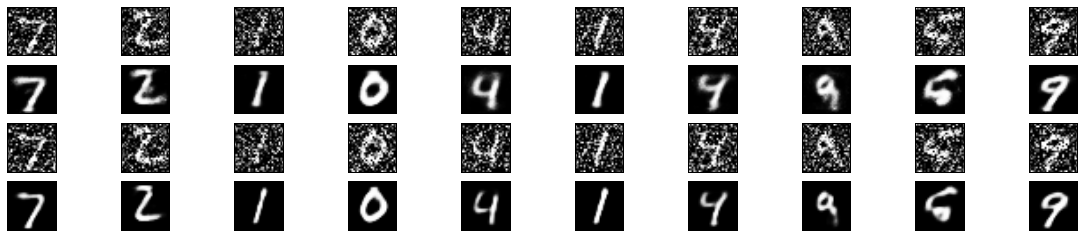

In [22]:
# use Matplotlib (don't ask)
%matplotlib inline
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(4, n, i + 1)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + n)
    plt.imshow(nr_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display original
    ax = plt.subplot(4, n, i + 1 + 2*n)
    plt.imshow(X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(4, n, i + 1 + 3*n)
    plt.imshow(r_decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

In [23]:
print("Mean of non-regularized coded form: {:6.4f} \nMean of regularized coded form    : {:6.4f}"
      .format(nr_encoded_imgs.mean(), r_encoded_imgs.mean()))

Mean of non-regularized coded form: 2.8564 
Mean of regularized coded form    : 0.5684


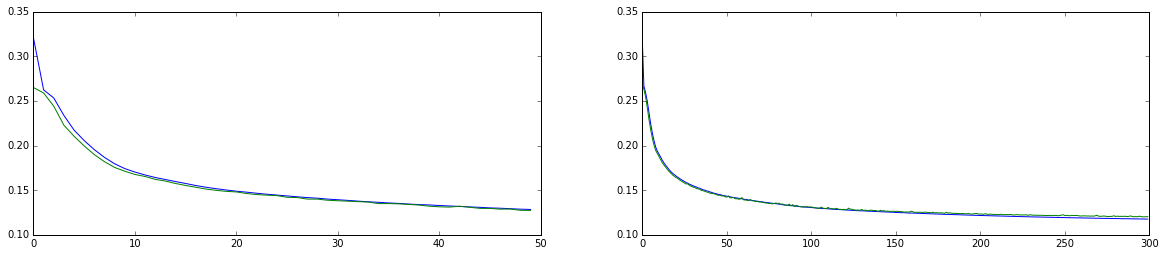

In [26]:
fig = plt.figure(figsize=(20,4))
#train_pred_fit
plt.subplot(1,2,1)
plt.plot(no_reg_train.history['loss'])
plt.plot(no_reg_train.history['val_loss'])

plt.subplot(1,2,2)
plt.plot(reg_train.history['loss'])
plt.plot(reg_train.history['val_loss'])

plt.show()